# Assignment 3: Convolutional Neural Networks (50 marks total)
### Due: October 17 at 11:59pm

### Name: Hiu Sum Yuen

The goal of this assignment is to apply Convolutional Neural Networks (CNNs) in PyTorch for image classification.

## Part 1: MLP vs. CNN

### Step 0: Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Step 1: Data Loading & Preprocessing (11 marks)

This assignment will use the CIFAR-10 dataset (*available via torchvision.datasets*). CIFAR-10 is a smaller version of the ImageNet dataset, that contains 60,000 32×32 color images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

The first step is to define the transformations for the training and testing datasets. In this case, we will apply a random horizontal flip. Apply any other transformations that are required.

In [2]:
# TODO: define transforms for train and test sets (2 marks)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

The next step is to load the training and testing datasets and split the training data into training and validation sets. You can consider 20% of the training dataset will be used for validation. You can use a batch size of 64 for all the datasets.

In [ ]:
# TODO: Load Datasets (1 mark)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                           download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                          download=True, transform=transform_test)

# TODO: Split train into train + validation (1 mark)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# TODO: Data loaders (1 mark)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100.0%


For this assignment, we will compare the performance of a feed-forward network (MLP) with a convolutional neural network (CNN). We will need to define a separate class to represent each model.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Your MLP class should have the following minimum requirements:
- At least 3 layers with ReLU activations
- At least 500 hidden units per layer
- Softmax output layer for 10 classes

Print a summary of the model architecture (number of parameters, layer shapes)

In [5]:
# TODO: Define Neural Network Model (3 marks)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(-1, 32*32*3)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

# Create model and print summary
mlp_model = MLP().to(device)
print("MLP Model Summary:")
print(mlp_model)
print(f"Total parameters: {sum(p.numel() for p in mlp_model.parameters())}")

MLP Model Summary:
MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Total parameters: 1969930


Your CNN class should have the following minimum requirements:
- At least 3 convolutional layers with ReLU activations
  - Example output for 3 layers: 32 feature maps -> 64 feature maps -> 128 feature maps
- At least 2 max-pooling layers
- At least 1 fully connected layer before the output
- Softmax output layer for 10 classes
- Use dropout to improve generalization

Print a summary of the model architecture (number of parameters, layer shapes)

In [6]:
# TODO: Define CNN Model (3 marks)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Create model and print summary
cnn_model = CNN().to(device)
print("CNN Model Summary:")
print(cnn_model)
print(f"Total parameters: {sum(p.numel() for p in cnn_model.parameters())}")

CNN Model Summary:
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Total parameters: 1147466


### Step 3: Define Training and Testing Loops (7 marks)

Next, you will need to define the loss criterion and the optimizer. Select an appropriate criterion. For the optimizer, use Adam with a constant learning rate of 0.001.

In [7]:
# TODO: Define loss criterion and optimizer (2 marks)
criterion = nn.CrossEntropyLoss()

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

Since we are evaluating the performance of two different models, we can create functions for both the training and validation loops. For each loop, you should print the average loss and the accuracy for each epoch.

In [8]:
# TODO: Training loop (3 marks)
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

In [9]:
# TODO: Validation loop (2 marks)
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

### Step 4: Train, Evaluate and Visualize (11 marks)

We can also create functions for plotting the training and validation losses over the epochs and for creating a confusion matrix.

In [10]:
# TODO: Create plotting functions (2 marks)
def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.xticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

Now that we have defined our required functions, we can train, evaluate and visualize the results for both models. You can use 20 epochs for both models.

In [11]:
# TODO: Run Training and validation loops for NN (2 marks)
mlp_train_losses = []
mlp_val_losses = []
mlp_train_accs = []
mlp_val_accs = []

epochs = 20
print("Training MLP...")
for epoch in range(epochs):
    train_loss, train_acc = train(mlp_model, train_loader, mlp_optimizer, criterion, device)
    val_loss, val_acc = validate(mlp_model, val_loader, criterion, device)
    
    mlp_train_losses.append(train_loss)
    mlp_val_losses.append(val_loss)
    mlp_train_accs.append(train_acc)
    mlp_val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Training MLP...
Epoch 1/20:
  Train Loss: 1.9149, Train Acc: 30.28%
  Val Loss: 1.7803, Val Acc: 35.79%
Epoch 2/20:
  Train Loss: 1.7970, Train Acc: 35.30%
  Val Loss: 1.6975, Val Acc: 37.87%
Epoch 3/20:
  Train Loss: 1.7473, Train Acc: 37.63%
  Val Loss: 1.6474, Val Acc: 41.24%
Epoch 4/20:
  Train Loss: 1.7134, Train Acc: 38.73%
  Val Loss: 1.6353, Val Acc: 41.35%
Epoch 5/20:
  Train Loss: 1.6867, Train Acc: 39.54%
  Val Loss: 1.6234, Val Acc: 41.72%
Epoch 6/20:
  Train Loss: 1.6731, Train Acc: 39.85%
  Val Loss: 1.6004, Val Acc: 42.56%
Epoch 7/20:
  Train Loss: 1.6604, Train Acc: 40.47%
  Val Loss: 1.5605, Val Acc: 43.56%
Epoch 8/20:
  Train Loss: 1.6503, Train Acc: 41.16%
  Val Loss: 1.5652, Val Acc: 44.49%
Epoch 9/20:
  Train Loss: 1.6399, Train Acc: 41.53%
  Val Loss: 1.5507, Val Acc: 44.34%
Epoch 10/20:
  Train Loss: 1.6310, Train Acc: 41.58%
  Val Loss: 1.5430, Val Acc: 44.38%
Epoch 11/20:
  Train Loss: 1.6229, Train Acc: 42.17%
  Val Loss: 1.5267, Val Acc: 45.76%
Epoch 12/20:
 

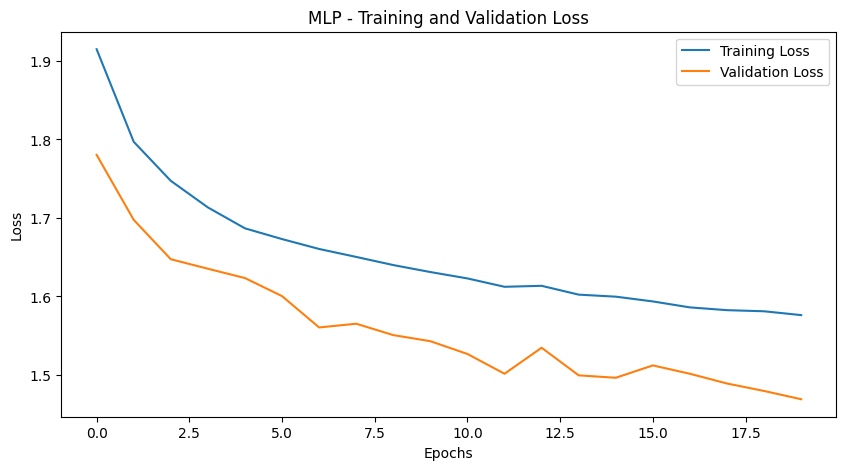

In [12]:
# TODO: Plot losses for NN (1 mark)
plot_losses(mlp_train_losses, mlp_val_losses, "MLP")

In [13]:
# TODO: Run Training and validation loops for CNN (2 marks)
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accs = []
cnn_val_accs = []

print("Training CNN...")
for epoch in range(epochs):
    train_loss, train_acc = train(cnn_model, train_loader, cnn_optimizer, criterion, device)
    val_loss, val_acc = validate(cnn_model, val_loader, criterion, device)
    
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    cnn_train_accs.append(train_acc)
    cnn_val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Training CNN...
Epoch 1/20:
  Train Loss: 1.5834, Train Acc: 41.60%
  Val Loss: 1.2711, Val Acc: 53.79%
Epoch 2/20:
  Train Loss: 1.1883, Train Acc: 57.33%
  Val Loss: 1.0341, Val Acc: 63.01%
Epoch 3/20:
  Train Loss: 1.0320, Train Acc: 62.87%
  Val Loss: 0.9155, Val Acc: 67.61%
Epoch 4/20:
  Train Loss: 0.9307, Train Acc: 67.08%
  Val Loss: 0.8558, Val Acc: 69.92%
Epoch 5/20:
  Train Loss: 0.8638, Train Acc: 69.54%
  Val Loss: 0.8359, Val Acc: 70.40%
Epoch 6/20:
  Train Loss: 0.8159, Train Acc: 71.25%
  Val Loss: 0.7797, Val Acc: 72.78%
Epoch 7/20:
  Train Loss: 0.7756, Train Acc: 72.73%
  Val Loss: 0.7464, Val Acc: 74.00%
Epoch 8/20:
  Train Loss: 0.7455, Train Acc: 73.88%
  Val Loss: 0.7315, Val Acc: 74.11%
Epoch 9/20:
  Train Loss: 0.7113, Train Acc: 75.14%
  Val Loss: 0.6999, Val Acc: 76.22%
Epoch 10/20:
  Train Loss: 0.6875, Train Acc: 75.93%
  Val Loss: 0.7029, Val Acc: 75.52%
Epoch 11/20:
  Train Loss: 0.6729, Train Acc: 76.56%
  Val Loss: 0.6794, Val Acc: 76.55%
Epoch 12/20:
 

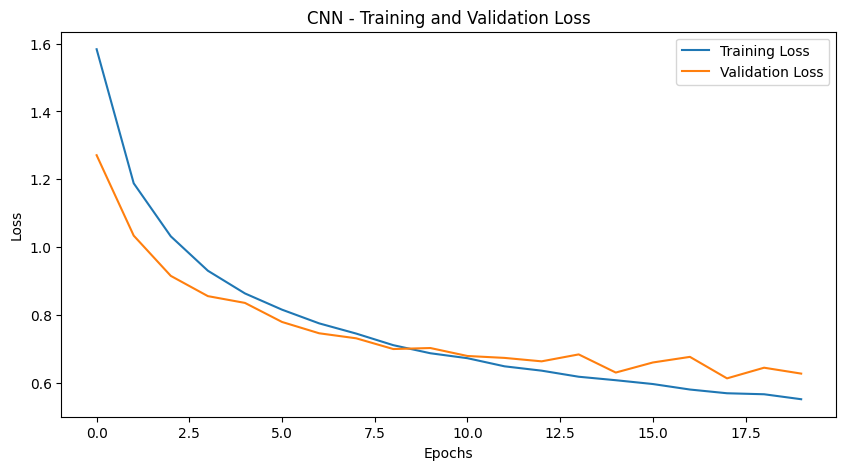

In [14]:
# TODO: Plot losses for CNN (1 mark)
plot_losses(cnn_train_losses, cnn_val_losses, "CNN")


### Step 5: Model Testing (3 marks)

Now that we have compared the two models, we can select the best one and use the testing data to see how well this model generalizes.

In [15]:
# TODO: Test loop (3 marks)
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# Test both models
print("Testing MLP...")
mlp_test_loss, mlp_test_acc = test(mlp_model, test_loader, device)
print(f"MLP Test Loss: {mlp_test_loss:.4f}, Test Accuracy: {mlp_test_acc:.2f}%")

print("Testing CNN...")
cnn_test_loss, cnn_test_acc = test(cnn_model, test_loader, device)
print(f"CNN Test Loss: {cnn_test_loss:.4f}, Test Accuracy: {cnn_test_acc:.2f}%")

Testing MLP...
MLP Test Loss: 1.5427, Test Accuracy: 44.44%
Testing CNN...
CNN Test Loss: 0.5870, Test Accuracy: 79.95%


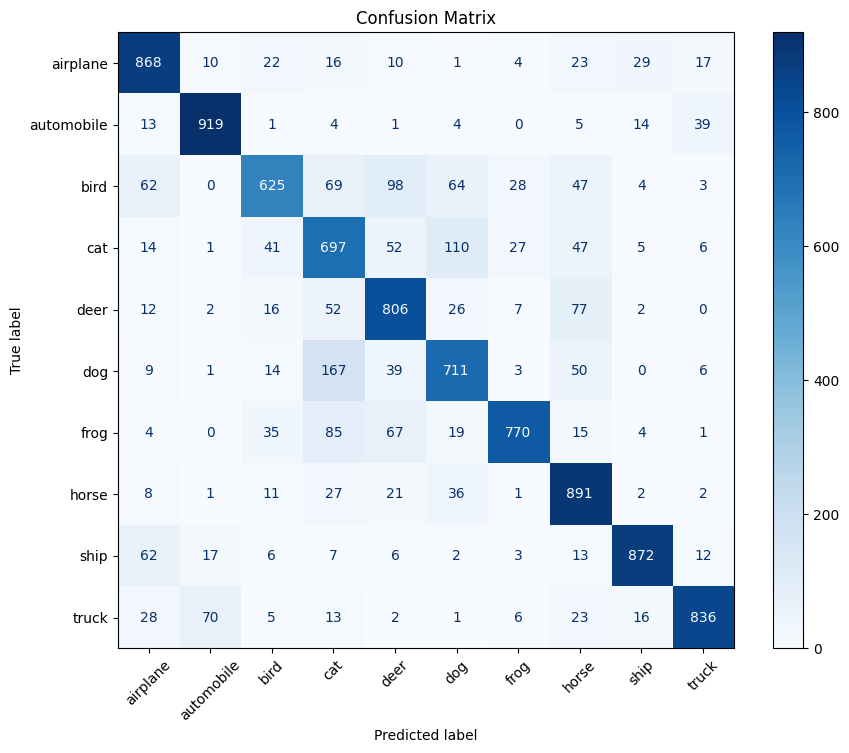

In [16]:
# Plot confusion matrix for the best model
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Use CNN as it typically performs better
plot_confusion_matrix(cnn_model, test_loader, device, class_names)

### Questions (12 marks)
1. How do your training, validation, and test accuracies compare for your best model? What does this tell you about the model's generalization?
1. Examine your results for both models. Do you see signs of overfitting or underfitting? Explain what indicates this.
1. How can we further improve the results? Provide two suggestions.
1. If your model performs poorly on certain classes (check your confusion matrix), what does that suggest about those images or their features?
1. What is the role of dropout in the CNN? How might removing dropout change your results?
1. What other data transformations did you include and why? Are there any other data augmentation methods that we could use for this dataset?

*ANSWER HERE*

### Process Description (4 marks)
Please describe the process you used to create your code. Cite any websites or generative AI tools used. You can use the following questions as guidance:
1. Where did you source your code?
1. In what order did you complete the steps?
1. If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?
1. Did you have any challenges? If yes, what were they? If not, what helped you to be successful?

*DESCRIBE YOUR PROCESS HERE - BE SPECIFIC*

## Part 2: Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating
while working on this assignment.


*ADD YOUR THOUGHTS HERE*